In [31]:
from cppbridge import *
from mcmc_analytics import *

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Inferring parameters with EHMM samplers for Poisson model 1

The experiments are for the models and samplers presented in the paper\
[1] Shestopaloff A.Y, Neal R.M. Sampling Latent States for High-Dimensional Non-Linear State Space Models with the Embedded HMM Method

---
## Model specification
Here we will try to recover the parameters of the same non-linear SSM we used in the experiments with Poisson model 1 with known parameters (see `sampling_linpoiss.ipynb` notebook). To do that we will specify the priors for each of the parameters driving the model: $a_i$ and $\rho$ for transition model and $c_i$ and $d_i$ for the observation model.

Out chosen priors are as follows:
* $a_{i}\sim\mathrm{U}(-1,1)$: for VAR(1) process we need our coefficients to be between -1 and 1
* $\rho\sim\mathrm{U}(0,1)$
* $c_{i}\sim\mathcal{N}(0,\sigma^{2})$
* $d_{i}\sim\mathcal{N}(0,\sigma^{2})$ \
where $\sigma^{2}$ is a large number to make the prior vague

In [33]:
# Set up the transition model with unknown parameters
T = 250
n = 10
A = DiagonalMatrixParam()
aa = 0.89
bb = 0.91
A.parametrize(n, DistributionType.UNIFORM, (aa, bb), minx=aa, maxx=bb)
Q = SymmetricMatrixParam()
a = 0.69
b = 0.71
x_var = 1.
Q.parametrize(n, DistributionType.UNIFORM, (a, b), x_var, minx=a, maxx=b)
# Prior mean is always zero
prior_mean = np.zeros(n)
# The prior covariance will be re-calculated for each newly accepted parameters, including for the first iteration 
# so below will not be used but still required to intialize the class 
Q_init = np.eye(n)
trm = TransitionSpec(A, Q, prior_mean, Q_init)

In [34]:
# Set up the observation model with unknown parameters
C = DiagonalMatrixParam()
var = 1e-4 / 3
C.parametrize(n, DistributionType.NORMAL, (0.6, np.sqrt(var)))
D = DiagonalMatrixParam()
D.parametrize(n, DistributionType.NORMAL, (-0.4, np.sqrt(var)))
u = ConstParam(np.ones(n), parametrised=True)
obsm = ObservationSpec(ModelType.LINEAR_POISSON, C, D, u)

## Sampler specification
### Embedded HMM sampling scheme
In these experiments we will only be using EHMM sampler.

In [35]:
# Specify EHMM scheme
nupd = 50  # number of parameter updates between the scheme runs
pool_sz = 50
ehmm_sampler = SamplerSpec(SamplerType.EHMM, pool_size=pool_sz, num_parameter_updates=nupd)

## Observations
We need the observations, on which to run the samplers. The data we use is the synthetic data, generated in `models.ipynb` notebook. In this experiemtns we will try and recover the parameters used to generate that data as well as the latent states.

In [36]:
model = "gauss_poiss1_4819470358185372509"
dataprovider = model + "_data.h5"
dataspec = Data(dataprovider)

## Simulation    
To run the simulation we need to provide the initial sample $\mathbf{x}_0$ to start off the sampler, and specify the parameters of the simulation. We set $\mathbf{x}_0=\mathbf{0}$ and run 5 simulations for $10 000$ iterations each, starting with the different seed for randomisation.

In [37]:
n_iter_ehmm = 10000
x_init = np.zeros((n, T))
seeds = np.array([5], dtype=int)
scales_ehmm = np.array([0.05, 0.2])
reverse = False
simulation_ehmm = SimulationSpec(n_iter_ehmm, seeds, x_init, scaling=scales_ehmm, reverse=reverse)

In [38]:
# Simulation with EHMM sampler
ehmm_session_name = f"paramtest_ehmm50_noreverse_lp"
mcmc_ehmm_lp = MCMCsession(ehmm_session_name)
if mcmc_ehmm_lp.hasResults():
    mcmc_ehmm_lp.loadResults()
else:
    mcmc_ehmm_lp.init(T, trm, obsm, ehmm_sampler, simulation_ehmm, dataspec)
    mcmc_ehmm_lp.run()

Launched Baysis
Loaded model specifications.
HighFive WARNING "parametrised": data and hdf5 dataset have different types: Integer8 -> Enum8
HighFive WARNING "reverse": data and hdf5 dataset have different types: Integer8 -> Enum8

Running sampler for paramtest_ehmm50_noreverse_lp with 1 seeds:
	running with seed 5 ...
	Done in 508341ms
	results saved into ../data/paramtest_ehmm50_noreverse_lp_results_seed5.h5

######### All done #########
Loading results for seed5...		Done


---
## Analysis of the results
### Overview

In [39]:
ehmm_burnin = int(0.1 * (1 + reverse) * (n_iter_ehmm + 1))
ehmm_samples = mcmc_ehmm_lp.get_samples(ehmm_burnin)

In [40]:
ac_ehmm = getACF(mcmc_ehmm_lp.samples, ehmm_samples)
taus_ehmm = 1 + 2 * np.sum(ac_ehmm, axis=2)
meantaus_ehmm = np.mean(taus_ehmm)

In [41]:
ehmm_met_acc = 100 * np.mean(
    [acc[:T].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_lp.acceptances.items()])
ehmm_shift_acc = 100 * np.mean(
    [acc[T + 1:].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_lp.acceptances.items()])
ehmm_partrm_acc = 100 * np.mean([acc['trm'] / (n_iter_ehmm * nupd * (1 + reverse)) for _, acc in mcmc_ehmm_lp.param_acceptances.items()])
ehmm_parobm_acc = 100 * np.mean([acc['obsm'] / (n_iter_ehmm * nupd * (1 + reverse)) for _, acc in mcmc_ehmm_lp.param_acceptances.items()])
ehmm_overview = {"Num seeds": len(seeds),
                 "Num iter": n_iter_ehmm,
                 "Time per sample, ms": np.mean(list(mcmc_ehmm_lp.durations.values())) /
                                        list(mcmc_ehmm_lp.samples.values())[0].shape[0],
                 "Acceptance rate, autoregressive update, %": ehmm_met_acc,
                 "Acceptance rate, shift update, %": ehmm_shift_acc,
                 "Acceptance rate, param updates for transition model, %": ehmm_partrm_acc,
                 "Acceptance rate, param updates for observation model, %": ehmm_parobm_acc,
                 "Average autocorrelation time": meantaus_ehmm
                 }
overview = pd.DataFrame({"EHMM on Poisson model 1": ehmm_overview})
overview

,EHMM on Poisson model 1
"Acceptance rate, autoregressive update, %",88.985484
"Acceptance rate, param updates for observation model, %",45.656000
"Acceptance rate, param updates for transition model, %",43.122000
"Acceptance rate, shift update, %",63.050387
Average autocorrelation time,15.867221
Num iter,10000.000000
Num seeds,1.000000
"Time per sample, ms",50.829017


In [42]:
ehmm_ar = np.stack(list(mcmc_ehmm_lp.acceptances.values()), axis=1)[:T].ravel() / (
            n_iter_ehmm * pool_sz * (1 + reverse))
ehmm_shift = np.stack(list(mcmc_ehmm_lp.acceptances.values()), axis=1)[T + 1:].ravel() / (
            n_iter_ehmm * pool_sz * (1 + reverse))
pd.DataFrame(dict(ehmm_ar=ehmm_ar, ehmm_shift=np.append(ehmm_shift, [np.nan] * len(seeds)))).describe()

,ehmm_ar,ehmm_shift
count,250.000000,249.000000
mean,0.889855,0.630504
std,0.050093,0.121396
min,0.696844,0.255822
25%,0.866278,0.553000
50%,0.902844,0.647956
75%,0.928051,0.723998
max,0.956602,0.845700


### Test equality of parameters

In [44]:
params_names = ["$a_i$", "$\\rho$", "$c_i$", "$d_i$", "$u$"]
true_values = dict(zip(params_names, [0.9, 0.7, 0.6, -0.4, 1.]))
psamples = mcmc_ehmm_lp.get_paramSamples(ehmm_burnin, params_names)
params_ttest = ttest(psamples, list(true_values.values()))
pd.DataFrame({"p-value":params_ttest}, index=params_names)

,p-value
$a_i$,0.000000e+00
$\rho$,3.939226e-03
$c_i$,4.405276e-69
$d_i$,9.593408e-02
$u$,0.000000e+00


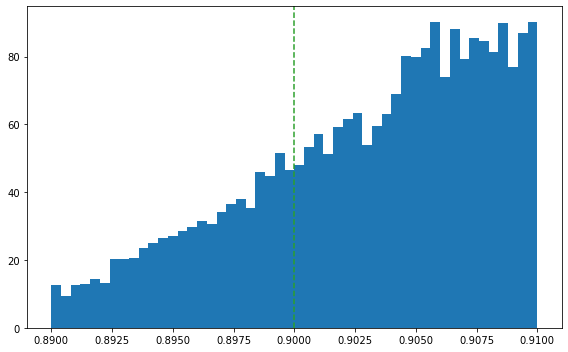

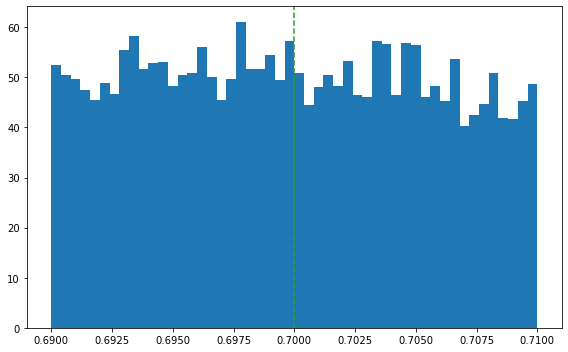

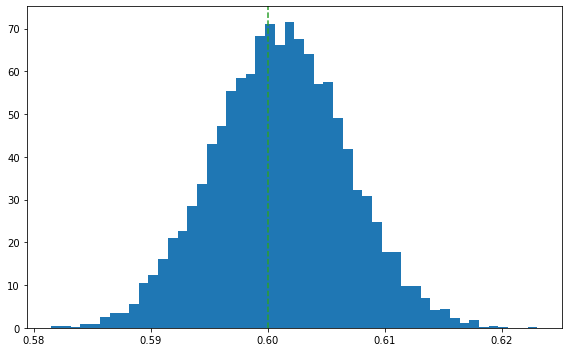

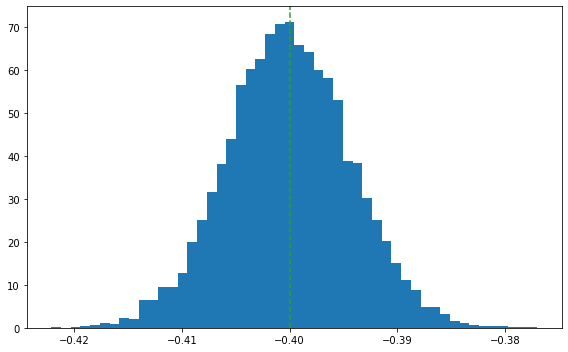

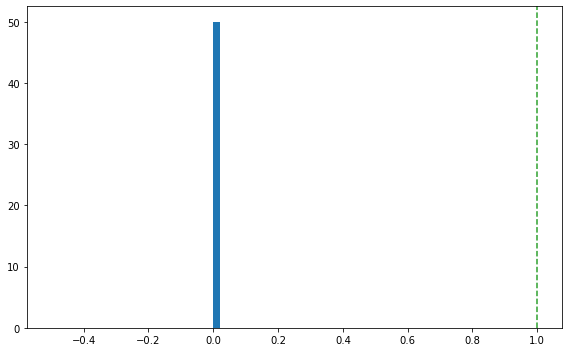

In [45]:
for pname in params_names:
    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(psamples[pname], bins=50, density=True)
    ax.vlines(true_values[pname], 0, 1, transform=ax.get_xaxis_transform(), linestyles='dashed', color="C2")
    plt.tight_layout()
    plt.show()

### Convergence analysis

In [ ]:
epsr = getEPSR(mcmc_ehmm_lp.samples, ehmm_burnin)

In [ ]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, epsr[:, i])
ax.set_xmargin(0.01)
ax.locator_params(axis='y', nbins=10)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# for i, tick in enumerate(ax.yaxis.get_ticklabels()):
#     if i % 2 != 0:
#         tick.set_visible(False) 
plt.tight_layout()
# plt.savefig(OUTPUTS_PATH/"epsr_met_lp.png", dpi=300, format='png')
plt.show();

### Autocorrelation

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, taus_ehmm[i, :]*overview.loc['Time per sample, ms', 'EHMM on Poisson model 1'])
ax.set_xmargin(0.01)
ax.set_xlabel("time $t$")
ax.set_ylabel("autocorrelation time, ms")
plt.tight_layout()
# plt.savefig(OUTPUTS_PATH/"taus_ehmm_lp.png", dpi=300, format='png')
plt.show();

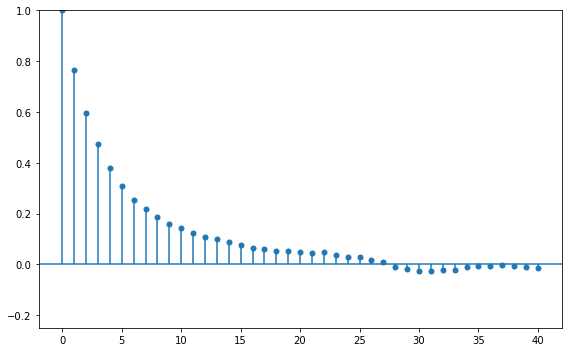

In [47]:
t = 0
d = 0

fig, ax = plt.subplots(figsize=(8,5))
plotACF(ac_ehmm, t, d, ax)
ax.set_ylim(-0.25,1)
plt.tight_layout()
# plt.savefig(OUTPUTS_PATH/f"acf_ehmm_{t}-{d}_lp.png", dpi=300, format='png')
plt.show();

### Trace plots

In [ ]:
plot_trace(ehmm_samples, t, d)

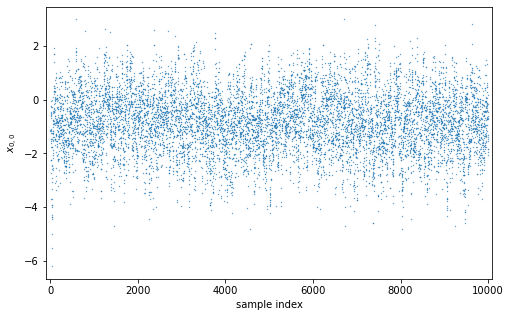

In [48]:
plot_mixing(mcmc_ehmm_lp.samples, t, d)

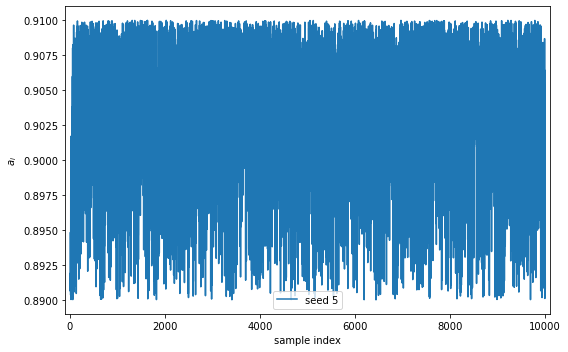

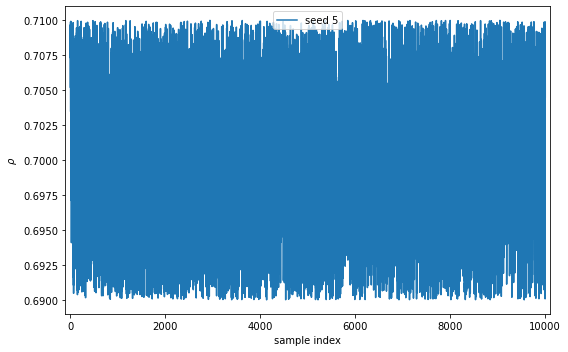

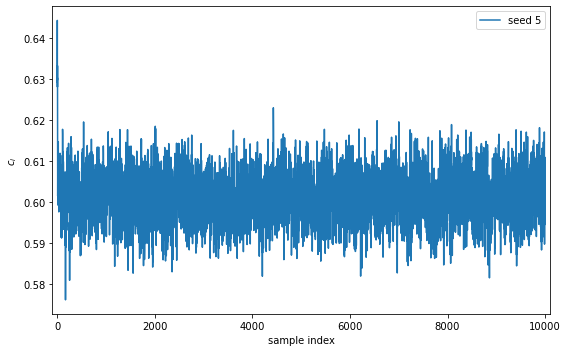

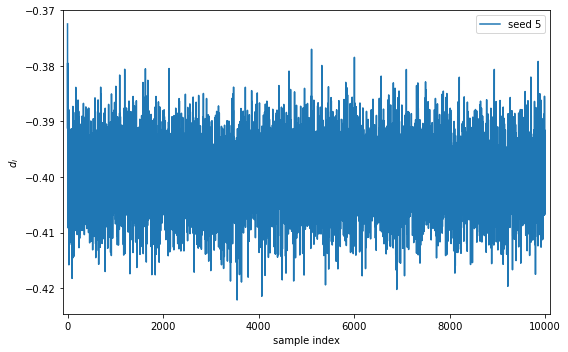

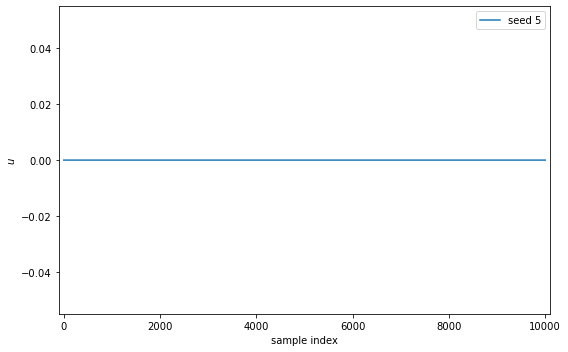

In [49]:
for idx, param_name in enumerate(params_names):
    fig, ax = plt.subplots(figsize=(8, 5))

    for seed in seeds:
        data = mcmc_ehmm_lp.get_paramSamples(0, params_names, forseed=seed)
        ax.plot(data.index, data[param_name], label=f"seed {seed}")

    ax.set_xmargin(0.01)
    ax.set_ylabel(param_name)
    ax.set_xlabel("sample index")
    ax.legend()
    plt.tight_layout()
    # plt.savefig(OUTPUTS_PATH / f"param_plotmix_{param_name}.png", dpi=300, format='png')
    plt.show()